In [74]:
library(ComplexHeatmap)
library(stringr)
library(ggplot2)
library(RColorBrewer)
library(cowplot)
library(pheatmap)
library(dplyr)
library(xlsx)
library(readxl)

set.seed(2000)

cols<-brewer.pal(11,"PuOr")
pal<-colorRampPalette(cols)
mycolors1<-pal(42)

cols2<-brewer.pal(9,"YlGnBu")
pal2<-colorRampPalette(cols2)
mycolors2<-pal2(42)


# 1 ALL PCA
### 1.2 RNA FPKM PCA

In [75]:
fpkm <- read_excel("fpkm.annot.xlsx")

In [76]:
select_samples <- function(tomato_FPKM_data){
    fpkm2 <- data.frame(tomato_FPKM_data)
    rownames(fpkm2) <- fpkm2$ID
    fpkm2 <- fpkm2[2:175]
    return(fpkm2)   
}
fpkm <- select_samples(fpkm)


In [77]:
head(fpkm,2)

,CD0h.1,CD0h.2,CD0h.3,C0h.1,C0h.2,C0h.3,D0h.1,D0h.2,D0h.3,CC12h.1,⋯,DD216h.3,CD216h.1,CD216h.2,CD216h.3,C216h.1,C216h.2,C216h.3,D216h.1,D216h.2,D216h.3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Solyc00g011560.1,0.09,0.13,0,0,0,0,0.44,0.19,0.26,0,⋯,0.35,0.42,0.5,0.09,0,0,0,0.24,0.67,0.04
Solyc00g011660.1,0.00,0.00,0,0,0,0,0.00,0.00,0.00,0,⋯,0.00,0.00,0.0,0.05,0,0,0,0.00,0.00,0.00


In [78]:
get_metadata <- function(samples){
    Var1 <- data.frame(str_split_fixed(samples, "h.", 2))

    Var1$Time <- as.numeric(gsub('[^0-9.]','', Var1$X1))
    Var1$Condition <- gsub("^([[:alpha:]]*).*", "\\1", Var1$X1)
    rownames(Var1) <- samples
    Var1 <- Var1[,c("X2", "Time", "Condition")]
    colnames(Var1) <- c("rep", "Time", "Condition")
    
    return(Var1)   
}

fpkm_metadata <- get_metadata(colnames(fpkm))
head(fpkm_metadata, 4)

,rep,Time,Condition
,<chr>,<dbl>,<chr>
CD0h.1,1,0,CD
CD0h.2,2,0,CD
CD0h.3,3,0,CD
C0h.1,1,0,C


In [138]:
PCA_fig <- function(pcaData, Pca.Var.Per, pc1, pc2, color="Time", shape="Condition", title="FPKM PCA"){
    p_PCA <- ggplot(data=pcaData,aes_string(x=paste0("PC",pc1),y=paste0("PC",pc2),color=color,shape=shape))+
      geom_point(size=2) +
      theme_bw()+theme(panel.grid=element_blank()) +
      xlab(paste("PC",pc1,"(",Pca.Var.Per[pc1],"%","variance)",sep="")) +
      ylab(paste("PC",pc2,"(",Pca.Var.Per[pc2],"%","variance)",sep="")) +
      scale_color_gradient2() +
      theme(legend.key.size=unit(4,'mm'), text = element_text(size=12)) + 
      coord_equal() +
      labs(title=title)
    
    return(p_PCA)
}



In [141]:
doRNApca <- function(df, meta_data, vars_N=3000){
    data <- as.data.frame(lapply(df, as.numeric))
    rownames(data) <- rownames(df)
    data[is.na(data)] <- 0
    data <- data[which(rowSums(data) > 0),]

    cg=names(tail(sort(apply(data, 1 , sd)), vars_N))
    #apply按行（'1'是按行取，'2'是按列取）取每一行的方差，从小到大排序，取最大的1000个
    data <- data[cg,]
    
    ## PCA 
    pca <- prcomp(t(data), scale=TRUE)
    pca.var <- pca$sdev^2
    pca.var.per <- round(pca.var/sum(pca.var)*100, 1)
    PCAmat <- as.data.frame(pca$x[,1:3])

    PCAmat <- cbind(PCAmat, meta_data)
    PCAmat <- cbind(PCAmat, t(data))
    #PCAmat$HAG <- factor(PCAmat$HAG, levels=sort(unique(PCAmat$HAG)))
    #PCAmat$HAG <- as.numeric(PCAmat$HAG)
    #PCAmat$HAG <- as.numeric(as.character(PCAmat$HAG))
    return(list(PCAmat=PCAmat, pca.var.per = pca.var.per))    
}

fpkm_PCA <- doRNApca(fpkm, fpkm_metadata, vars_N=3000)


In [142]:
head(fpkm_PCA$PCAmat,2)

,PC1,PC2,PC3,rep,Time,Condition,Solyc01g104030.3,Solyc09g007540.3,Solyc10g050440.2,Solyc01g074000.3,⋯,Solyc03g119210.1,Solyc01g109660.2,Solyc08g074480.1,Solyc12g044330.2,Solyc05g008895.1,Solyc08g078870.3,Solyc03g034370.1,Solyc12g094620.3,Solyc09g010800.5.1,Solyc09g075210.3
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD0h.1,-1.820171,-13.25308,32.13947,1,0,CD,29.49,76.74,25.21,19.93,⋯,288.89,2229.74,3012.13,1984.41,285.08,1244.82,747.19,6857.77,4288.54,758.06
CD0h.2,1.672188,-10.79435,30.64398,2,0,CD,37.05,72.72,47.37,20.98,⋯,307.10,2121.11,2983.49,2294.18,324.88,1349.20,750.09,7503.05,4321.57,680.50


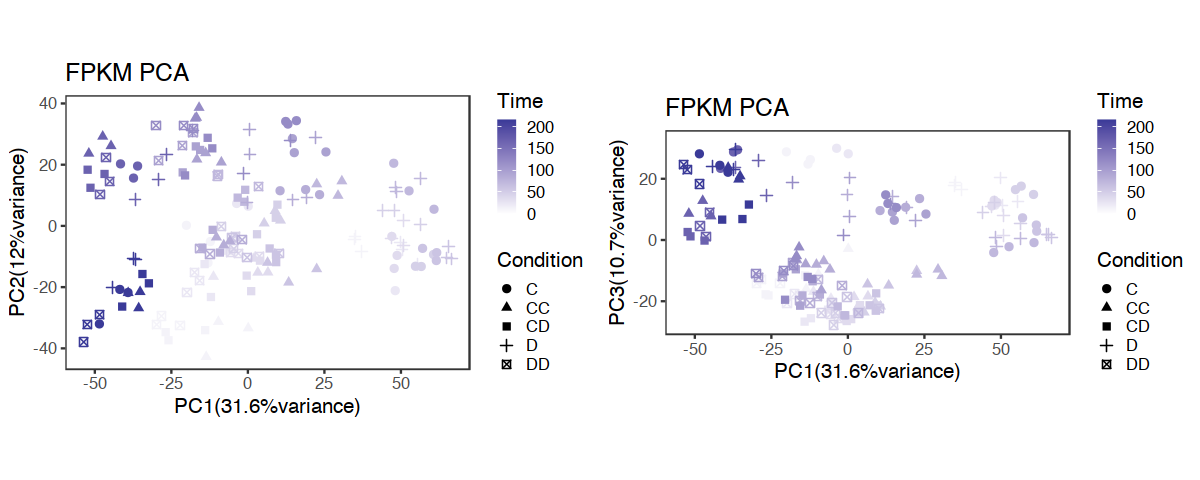

In [145]:
p_pca1 <- PCA_fig(fpkm_PCA$PCAmat, fpkm_PCA$pca.var.per, 1, 2, color="Time", shape="Condition", title="FPKM PCA")
p_pca2 <- PCA_fig(fpkm_PCA$PCAmat, fpkm_PCA$pca.var.per, 1, 3, color="Time", shape="Condition", title="FPKM PCA")

options(repr.plot.width=10, repr.plot.height=4)
plot_grid(p_pca1, p_pca2, ncol=2)


ggsave(p_pca1, file='fig/RNA_PCA12.pdf', width=5, height=5)
ggsave(p_pca2, file='fig/RNA_PCA13.pdf', width=5, height=5)

### 1.2 sugar

In [107]:
sugar <- read_excel("sugar.levels.xlsx")
rownames(sugar) <- sugar$Index
sugar <- data.frame(sugar)
sugar_data <- sugar[c(1:3,5:13),13:186]
sugar_SugarMetadata <- sugar[c(1:3,5:13),c(2,4)]


sugarSampleMetadata <- function(samples){
    Var1 <- data.frame(str_split_fixed(samples, "_", 2))$X2
    Var1 <- data.frame(str_split_fixed(Var1, "h.", 2))

    Var1$Time <- as.numeric(gsub('[^0-9.]','', Var1$X1))
    Var1$Condition <- gsub("^([[:alpha:]]*).*", "\\1", Var1$X1)
    rownames(Var1) <- samples
    Var1 <- Var1[,c("X2", "Time", "Condition")]
    colnames(Var1) <- c("rep", "Time", "Condition")
    
    return(Var1)   
}

SugarMetaData <- suppressWarnings(sugarSampleMetadata(colnames(sugar_data)))
head(SugarMetaData, 2)


Warning message:
“Setting row names on a tibble is deprecated.”


,rep,Time,Condition
,<chr>,<dbl>,<chr>
S_C0h.1,1,0,C
S_C0h.2,2,0,C


In [108]:
head(sugar_data,2)
head(sugar_SugarMetadata, 2)

,S_C0h.1,S_C0h.2,S_C0h.3,S_C120h.1,S_C120h.2,S_C120h.3,S_C12h.1,S_C12h.2,S_C12h.3,S_C168h.1,⋯,S_DD60h.3,S_DD72h.1,S_DD72h.2,S_DD72h.3,S_DD84h.1,S_DD84h.2,S_DD84h.3,S_DD96h.1,S_DD96h.2,S_DD96h.3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Suc,8.42546356,10.00109,7.49594127,16.9394563,17.6777468,18.4620683,18.9145304,19.9808041,17.2351266,26.9638331,⋯,18.7752294,16.5882188,12.6745437,17.0970631,22.9579815,21.7961478,17.8414553,22.6884751,19.8810398,20.3659981
Mal,0.022702231,0.0215187661,0.031376193,N/A,0.00697432558,0.0075957394,0.0152836204,0.0365618557,0.0129357095,0.0370845956,⋯,N/A,N/A,N/A,N/A,0.00778801236,0.00687298282,0.00565213373,0.0109690991,0.0104139653,0.00879881566


,Compounds,Class
,<chr>,<chr>
Suc,Sucrose,disaccharide
Mal,Maltose,disaccharide


In [146]:
doSugarPCA <- function(df, meta_data){
    data <- as.data.frame(lapply(df, as.numeric))
    rownames(data) <- rownames(df)
    
    data[is.na(data)] <- 0
    data <- data[which(rowSums(data) > 0),]
    
    ## PCA 
    pca <- prcomp(t(data), scale=TRUE)
    pca.var <- pca$sdev^2
    pca.var.per <- round(pca.var/sum(pca.var)*100, 1)
    PCAmat <- as.data.frame(pca$x[,1:3])

    PCAmat <- cbind(PCAmat, meta_data)
    PCAmat <- cbind(PCAmat, t(data))
    return(list(PCAmat=PCAmat, pca.var.per = pca.var.per))   
}

sugar_PCA <- suppressWarnings(doSugarPCA(sugar_data, SugarMetaData))

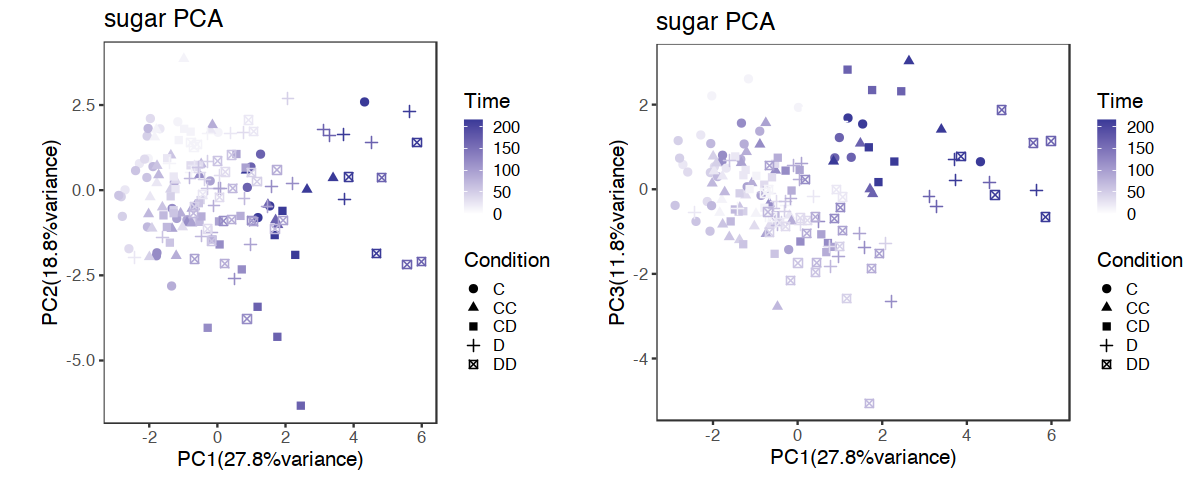

In [147]:
p_pca1 <- PCA_fig(sugar_PCA$PCAmat, sugar_PCA$pca.var.per, 1, 2, color="Time", shape="Condition", title="sugar PCA")
p_pca2 <- PCA_fig(sugar_PCA$PCAmat, sugar_PCA$pca.var.per, 1, 3, color="Time", shape="Condition", title="sugar PCA")

options(repr.plot.width=10, repr.plot.height=4)
plot_grid(p_pca1, p_pca2, ncol=2)


ggsave(p_pca1, file='fig/sugar_PCA12.pdf', width=5, height=5)
ggsave(p_pca2, file='fig/sugar_PCA13.pdf', width=5, height=5)

## 1.3 energy PCA

In [134]:
energy <- read_excel("energy.levels.xlsx")
energy <- data.frame(energy)
rownames(energy) <- energy$Index
energy_vars <- rownames(energy)[!(rownames(energy) %in% c("L-Cystine","Succinyl-CoA","Phenyllactate", "Oxaloacetate", "c-di-AMP", "dCMP", "dAMP", "dTMP", "dUMP", "Trehalose-6-phosphate"))]
energy <- energy[energy_vars,]
energy<- energy[,4:177] 
head(energy,2)

energySampleMetadata <- function(samples){
    Var1 <- data.frame(str_split_fixed(samples, "_", 2))$X2
    Var1 <- data.frame(str_split_fixed(Var1, "h.", 2))

    Var1$Time <- as.numeric(gsub('[^0-9.]','', Var1$X1))
    Var1$Condition <- gsub("^([[:alpha:]]*).*", "\\1", Var1$X1)
    rownames(Var1) <- samples
    Var1 <- Var1[,c("X2", "Time", "Condition")]
    colnames(Var1) <- c("rep", "Time", "Condition")
    
    return(Var1)   
}

energyMetaData <- suppressWarnings(energySampleMetadata(colnames(energy)))
head(energyMetaData, 2)


,E_CD0h.1,E_CD0h.2,E_CD0h.3,E_C0h.1,E_C0h.2,E_C0h.3,E_D0h.1,E_D0h.2,E_D0h.3,E_CC12h.1,⋯,E_DD216h.3,E_CD216h.1,E_CD216h.2,E_CD216h.3,E_C216h.1,E_C216h.2,E_C216h.3,E_D216h.1,E_D216h.2,E_D216h.3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
L-Arginine,14230.2284854589,12167.7780661593,13523.6539163657,14141.2839028932,15088.8244443591,10620.7887469361,16801.569729915,11566.8012204269,13094.6293687313,15572.1362766121,⋯,20643.0515597854,23906.8058491763,22508.1857927174,19502.9210128548,51223.6983486937,52078.0135539883,45727.9287329085,16460.9248423933,11505.5636105518,13573.2767046503
Acetyl-CoA,49.7910731394829,55.2813930110406,57.1766391166052,74.303624085664,63.0399148521773,68.3516825521184,65.7470609025903,48.5298857933033,49.7012844269613,69.3608247188199,⋯,58.3245632468214,79.0391607475033,90.9816480223579,67.0005297710499,85.2519201509754,79.3572761245219,76.9979911735708,61.4864545143759,60.5923266831175,59.9273524809759


,rep,Time,Condition
,<chr>,<dbl>,<chr>
E_CD0h.1,1,0,CD
E_CD0h.2,2,0,CD


In [148]:
doenergyPCA <- function(df, meta_data){
    data <- as.data.frame(lapply(df, as.numeric))
    rownames(data) <- rownames(df)
    
    data[is.na(data)] <- 0
    data <- data[which(rowSums(data) > 0),]
    
    ## PCA 
    pca <- prcomp(t(data), scale=TRUE)
    pca.var <- pca$sdev^2
    pca.var.per <- round(pca.var/sum(pca.var)*100, 1)
    PCAmat <- as.data.frame(pca$x[,1:3])

    PCAmat <- cbind(PCAmat, meta_data)
    PCAmat <- cbind(PCAmat, t(data))
    return(list(PCAmat=PCAmat, pca.var.per = pca.var.per))      
}

energy_PCA <- suppressWarnings(doSugarPCA(energy, energyMetaData))


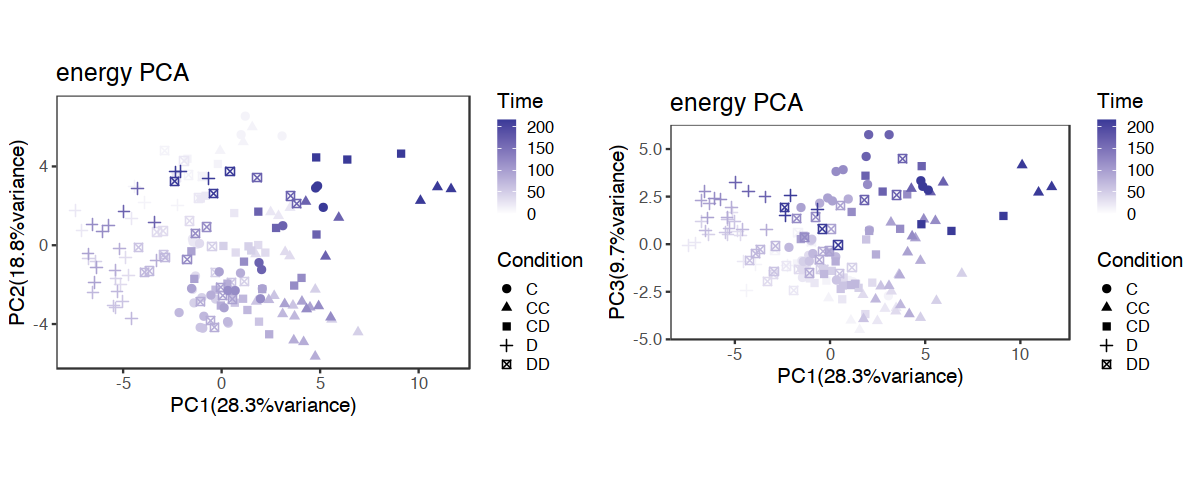

In [149]:
p_pca1 <- PCA_fig(energy_PCA$PCAmat, energy_PCA$pca.var.per, 1, 2, color="Time", shape="Condition", title="energy PCA")
p_pca2 <- PCA_fig(energy_PCA$PCAmat, energy_PCA$pca.var.per, 1, 3, color="Time", shape="Condition", title="energy PCA")

options(repr.plot.width=10, repr.plot.height=4)
plot_grid(p_pca1, p_pca2, ncol=2)

ggsave(p_pca1, file='fig/energy_PCA12.pdf', width=5, height=5)
ggsave(p_pca2, file='fig/energy_PCA13.pdf', width=5, height=5)


## 1.4 energy + sugar PCA

# 2 mfuzz

In [153]:
library(Mfuzz)

0 genes excluded.
0 genes excluded.
[1] 1.127407


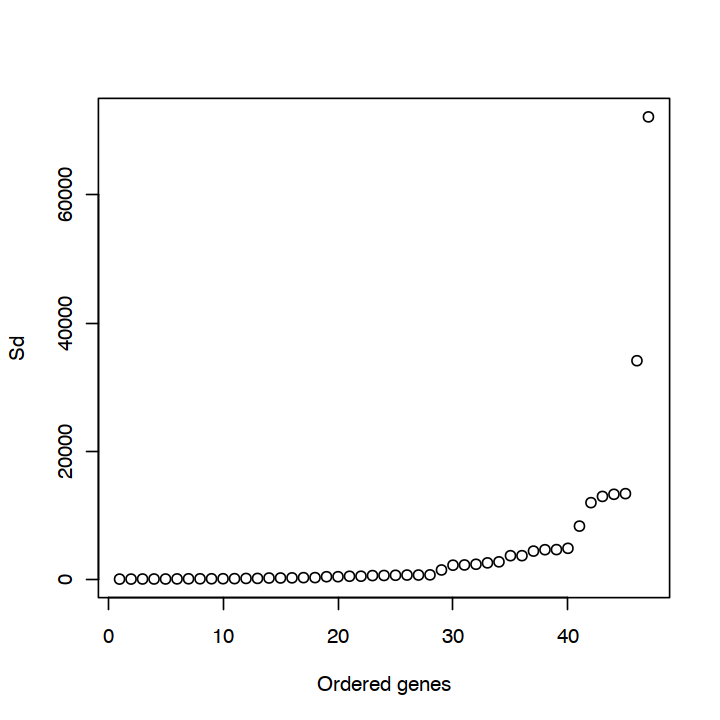

In [185]:
energy_mfuzz <- function(data, n=10){
    dat <- new('ExpressionSet', exprs=as.matrix(data))
    dat <- filter.NA(dat, thres = 0.25)
    dat <- fill.NA(dat, mode="mean")
    dat <- filter.std(dat, min.std=0)
    dat <- standardise(dat)
    
    m <- mestimate(dat)
    print(m)
    set.seed(2022)
    cl <- mfuzz(dat, c=n, m=m)
    return(list(cl=cl, dat=dat))
}

options(repr.plot.width=6, repr.plot.height=6)
cl_energy <- energy_mfuzz(t(energy_PCA$PCAmat[,7:53]), n=5)


[1] 13  6  6 11 11

Acetyl-CoA                   Adenine                   Inosine 
                        1                         1                         1 
                      ADP     D-Glucose-6-phosphate     D-Glucose-1-phosphate 
                        1                         1                         1 
     Glycerol-3-phosphate   6-Phosphogluconate-acid   D-Erythrose-4-phosphate 
                        1                         1                         1 
Sedoheptulose-7-phosphate                       UMP                       ATP 
                        1                         1                         1 
                      GDP 
                        1

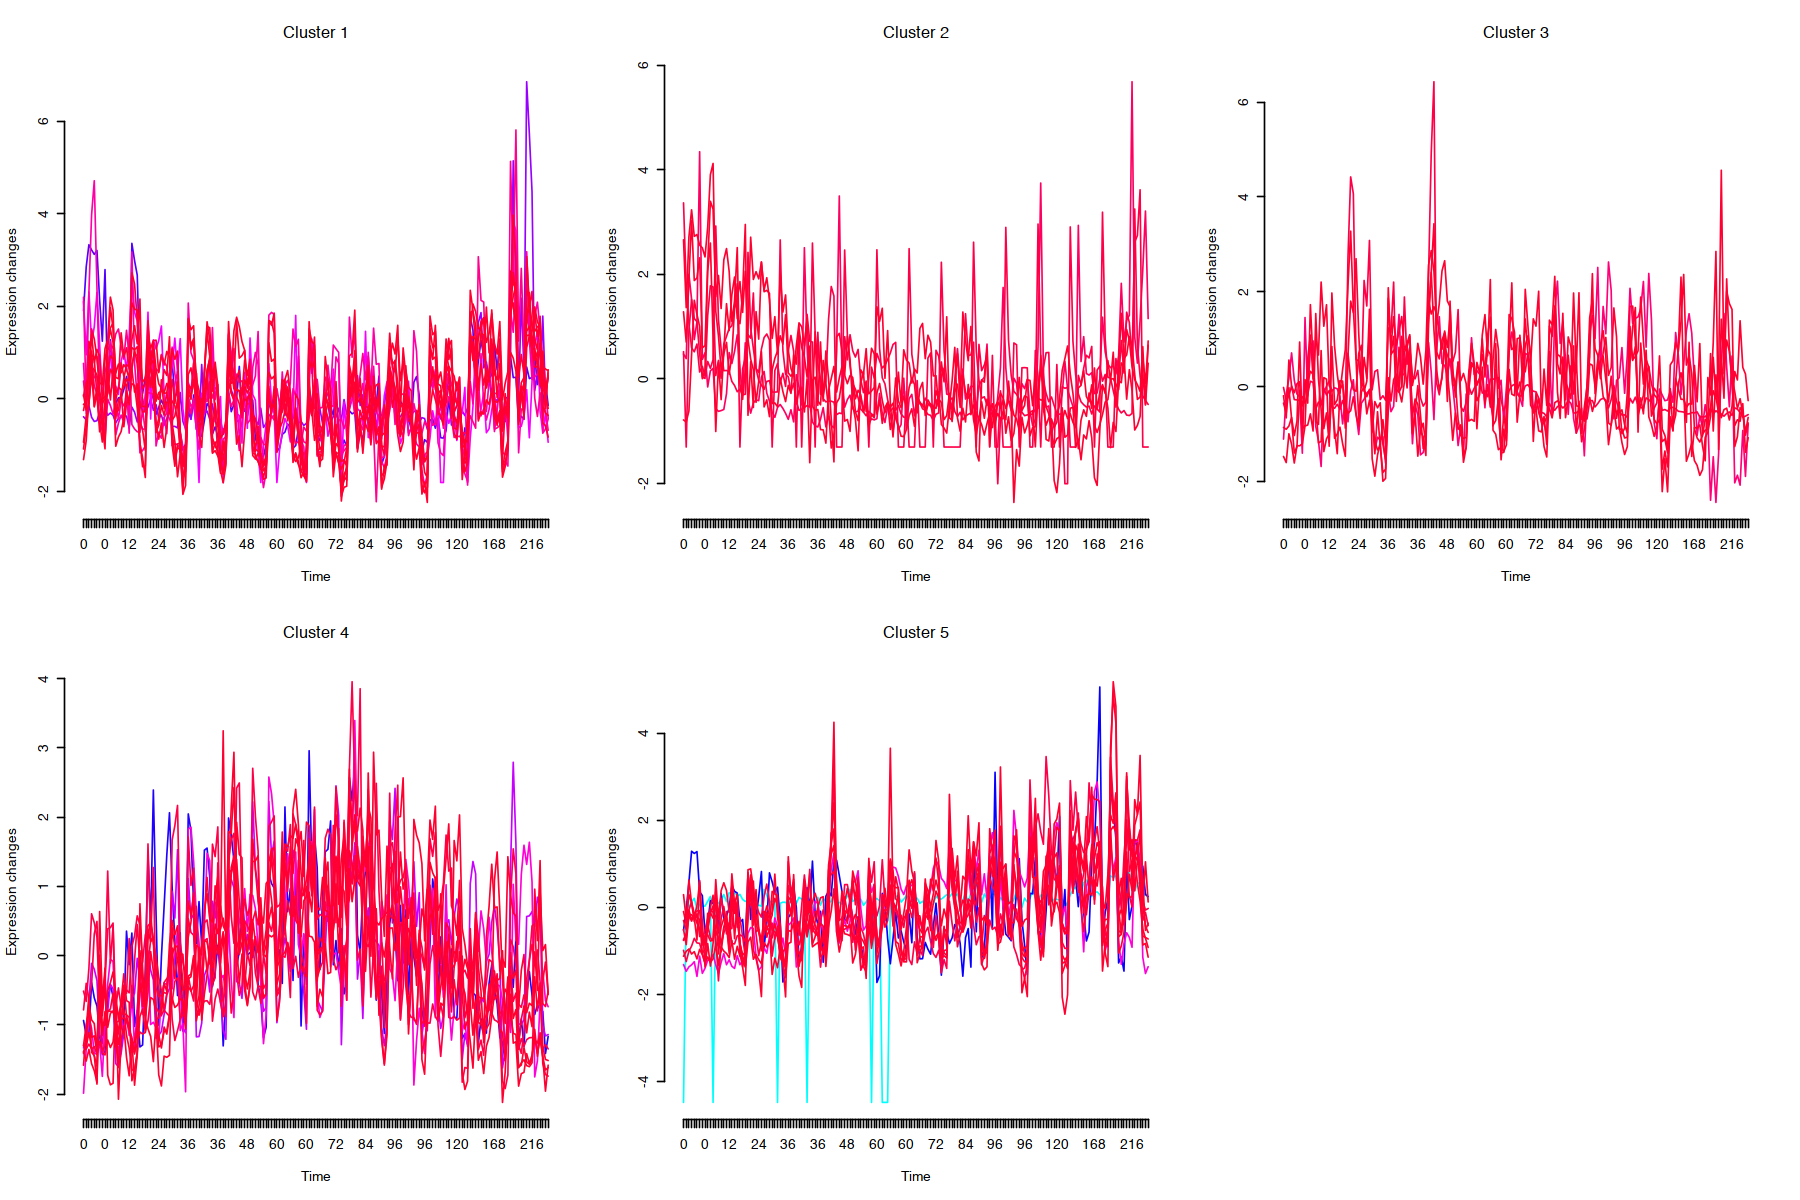

In [210]:

# 查看每个cluster中的基因个数
cl_energy$cl$size
# 提取某个cluster下的基因
cl_energy$cl$cluster[cl_energy$cl$cluster == 1]
# 查看基因和cluster之间的membership
#cl_energy$cl$membership


options(repr.plot.width=15, repr.plot.height=10)
mfuzz.plot(cl_energy$dat, cl_energy$cl, 
           mfrow=c(2,3), new.window= FALSE, 
           time.labels = energy_PCA$PCAmat$Time)


# 2.2 sugar

0 genes excluded.
0 genes excluded.
[1] 1.425216


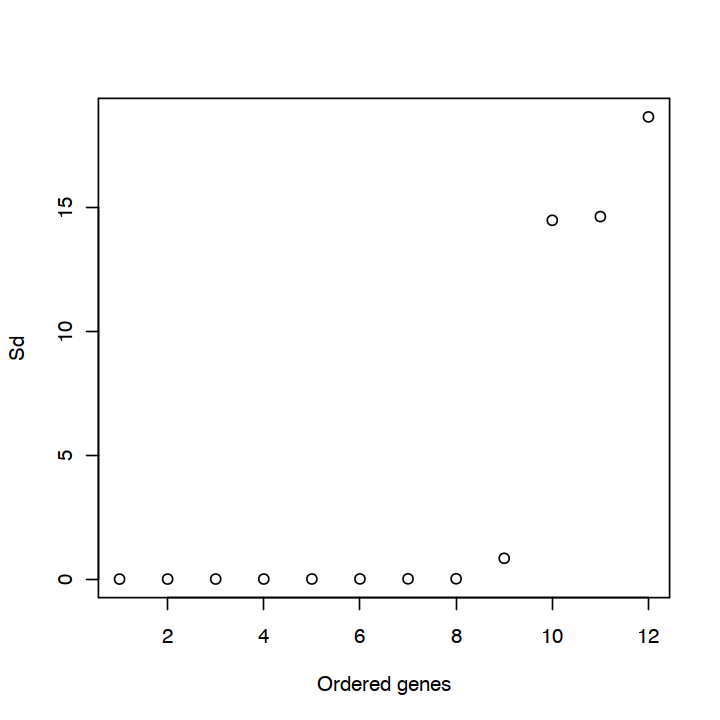

In [198]:
sugar_mfuzz <- function(data, n=10){
    dat <- new('ExpressionSet', exprs=as.matrix(data))
    dat <- filter.NA(dat, thres = 0.25)
    dat <- fill.NA(dat, mode="mean")
    dat <- filter.std(dat, min.std=0)
    dat <- standardise(dat)
    
    m <- mestimate(dat)
    print(m)
    set.seed(2022)
    cl <- mfuzz(dat, c=n, m=m)
    return(list(cl=cl, dat=dat))
}

options(repr.plot.width=6, repr.plot.height=6)
cl_sugar <- sugar_mfuzz(t(sugar_PCA$PCAmat[,7:18]), n=6)


[1] 2 4 2 1 2 1

Suc Mal 
  1   1

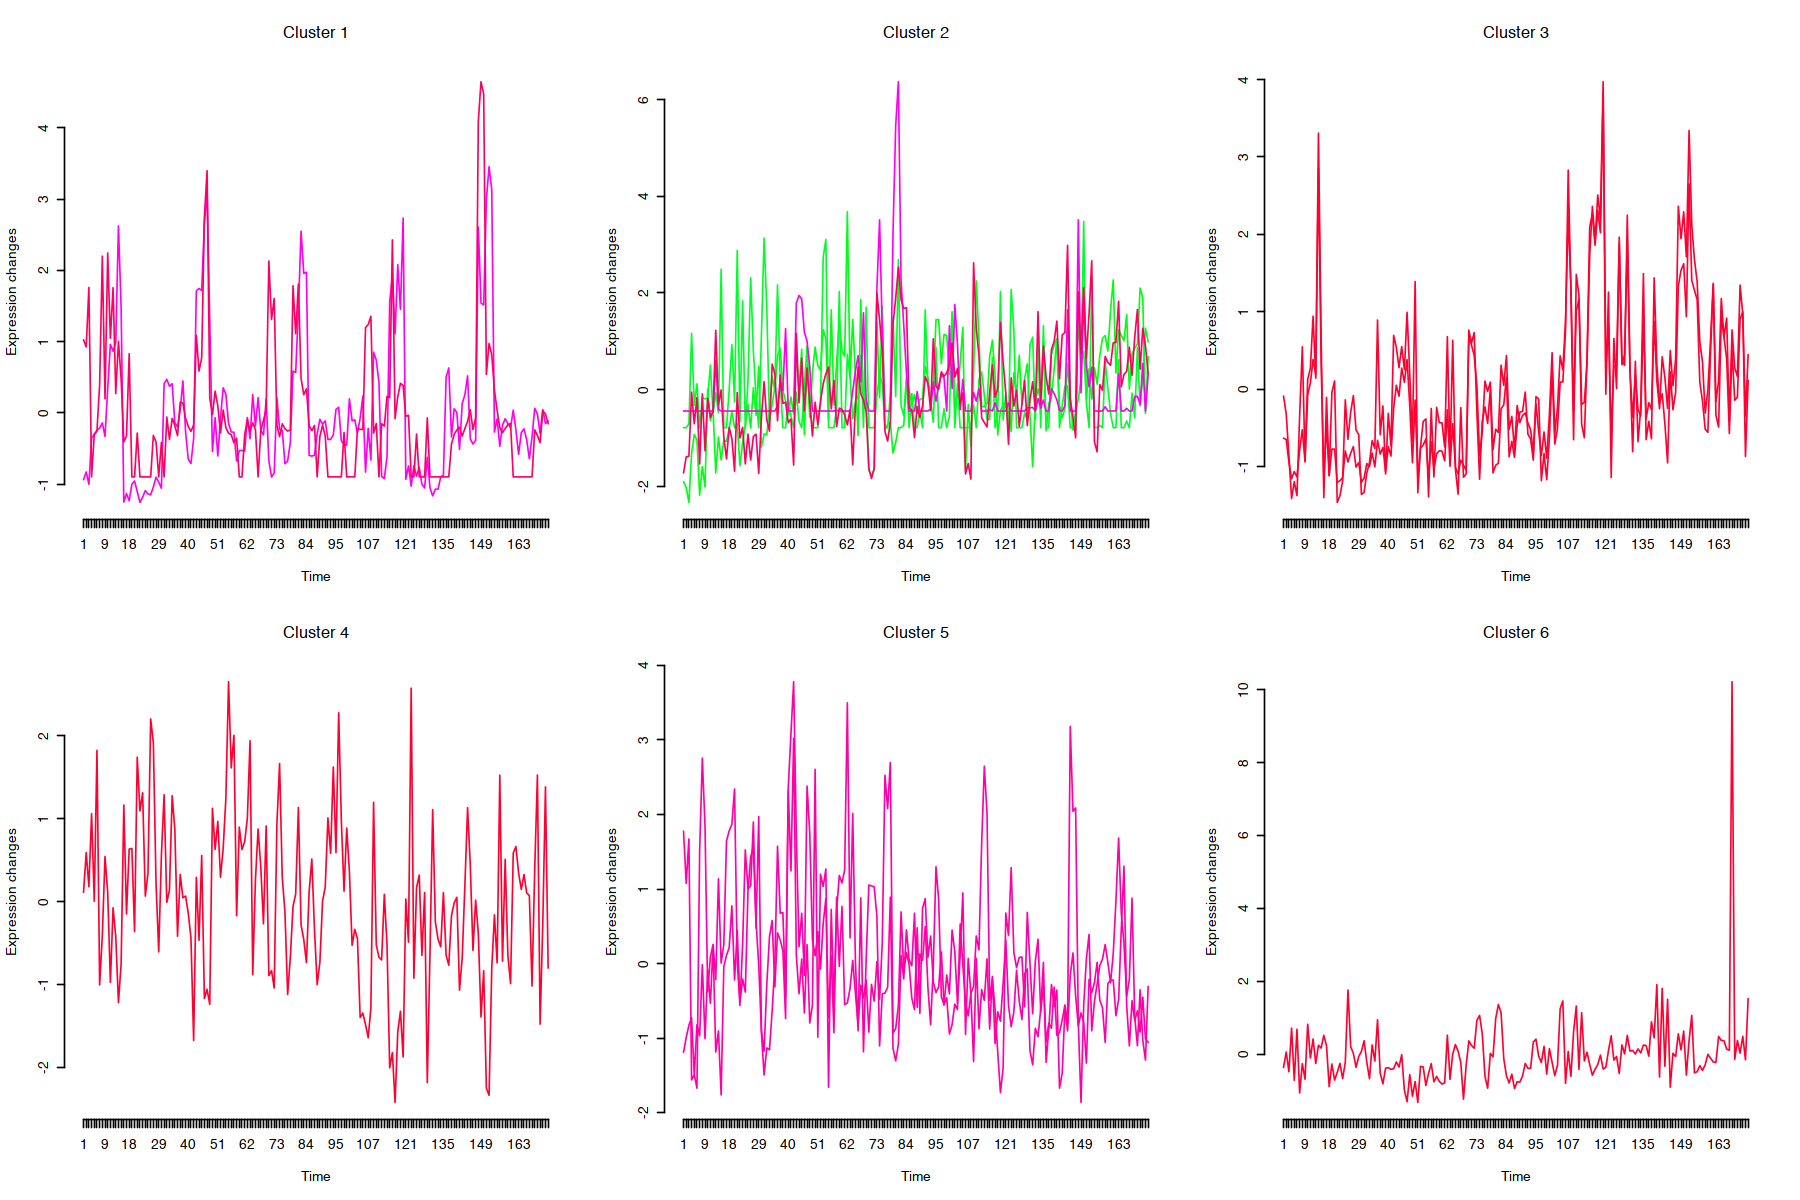

In [199]:

# 查看每个cluster中的基因个数
cl_sugar$cl$size
# 提取某个cluster下的基因
cl_sugar$cl$cluster[cl_sugar$cl$cluster == 1]
# 查看基因和cluster之间的membership
#cl_energy$cl$membership


options(repr.plot.width=15, repr.plot.height=10)
mfuzz.plot(cl_sugar$dat, cl_sugar$cl, mfrow=c(2,3), new.window= FALSE)


## 2.3 RNA mfuzz

In [ ]:
RNA_mfuzz <- function(data, n=10){
    dat <- new('ExpressionSet', exprs=as.matrix(data))
    dat <- filter.NA(dat, thres = 0.25)
    dat <- fill.NA(dat, mode="mean")
    dat <- filter.std(dat, min.std=0)
    dat <- standardise(dat)
    
    m <- mestimate(dat)
    print(m)
    set.seed(2022)
    cl <- mfuzz(dat, c=n, m=m)
    return(list(cl=cl, dat=dat))
}

options(repr.plot.width=6, repr.plot.height=6)
cl_RNA <- RNA_mfuzz(t(sugar_PCA$PCAmat[,7:18]), n=6)


In [205]:
head(fpkm_PCA$PCAmat,2)

,PC1,PC2,PC3,rep,Time,Condition,Solyc01g104030.3,Solyc09g007540.3,Solyc10g050440.2,Solyc01g074000.3,⋯,Solyc03g119210.1,Solyc01g109660.2,Solyc08g074480.1,Solyc12g044330.2,Solyc05g008895.1,Solyc08g078870.3,Solyc03g034370.1,Solyc12g094620.3,Solyc09g010800.5.1,Solyc09g075210.3
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD0h.1,-1.820171,-13.25308,32.13947,1,0,CD,29.49,76.74,25.21,19.93,⋯,288.89,2229.74,3012.13,1984.41,285.08,1244.82,747.19,6857.77,4288.54,758.06
CD0h.2,1.672188,-10.79435,30.64398,2,0,CD,37.05,72.72,47.37,20.98,⋯,307.10,2121.11,2983.49,2294.18,324.88,1349.20,750.09,7503.05,4321.57,680.50


In [206]:
unique(fpkm_PCA$PCAmat$Time)

[1]   0  12  24  36  48  60  72  84  96 120 168 216